# Import 

In [1]:
import numpy as np 
import scipy as sp
import pandas as pd
# import os
# import time
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
# import pickle
# import itertools
import networkx as nx
from matplotlib.colors import to_hex
from matplotlib.pyplot import cm
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from pathlib import Path
import matplotlib.colors as mcolors
# import networkx as nx
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, to_tree



In [2]:
# from module.dendorgram_utils import dendrogram_clustering
from module.data_prep import prep_grn_data, prep_go_meta, prep_tf_fam_dict, prep_foodweb_data, prep_recipe_data
from module.fvec import bipartite_cooarray
from module.enrichment_utils import get_clustersize_range, one_test, row_count_subset, make_GO_table, insert_line_break


In [3]:
save_things = False

# GRN vectors:

In [4]:
cwd = Path.cwd()
grn_processed_dir = cwd.parent / 'data' / 'grn' / 'processed'
grn_fig_dir = cwd.parent / 'figures' / 'grn'

if save_things:
    grn_fig_dir.mkdir(parents=True, exist_ok=True)

In [5]:
# Arabidopsis gene regulatory network and associated metadata
g_reg_edges, GO_bipartite_df = prep_grn_data()
go_meta_df = prep_go_meta()

GO_meta = pd.DataFrame({'node':GO_bipartite_df['GO'], 'type':GO_bipartite_df['GO']}) # dummy dataframe
tf_family_dict = prep_tf_fam_dict()

/Users/ssm47/Desktop/vectorisation/src/module/data_prep.py:6: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/grn/AtRegNet.csv', index_col=0)


## prepare data:

In [6]:
v = GO_bipartite_df.GO.value_counts()
single_GOs = v[v <=1].index.tolist() # GO terms that only appear once
multi_GOs = v[v >1].index.tolist() # GO terms that appear more than once


In [7]:
tfs = g_reg_edges.pre.unique() # all transcription factors
regulated_genes = g_reg_edges.post.unique() # all genes that are regulated
g_reg_ids = list(set(regulated_genes) | set(tfs)) # all nodes in the regulatory network
gene_ids = list(set(GO_bipartite_df.gene)) # genes that have GO labelling


In [8]:
# prepare the bipartite cooarray for GO terms
go_cooarray, row_names, col_names  = bipartite_cooarray(df=GO_bipartite_df, \
                                                        row_col=['gene', 'GO'], \
                                                        weight=False, \
                                                        row_order=None, \
                                                        col_order=None)

In [9]:
# dictionary to hold GO terms for each gene:
fast_go_dict = {}
for i in range(go_cooarray.shape[0]):
    ith_bool = go_cooarray.row == i
    ith_goterms = col_names[go_cooarray.col[ith_bool]]
    fast_go_dict[row_names[i]] = list(ith_goterms)


In [10]:
# GO terms that appear more than once associated with transcription factors:
tfs_go_counter = row_count_subset(csrarray=go_cooarray.tocsr(), r_ids=tfs, c_ids=multi_GOs, row_names=row_names, col_names=col_names)

In [11]:
# load the precomputed GO vectors for all genes:
grn_go_vectors = pd.read_parquet(grn_processed_dir / 'grn_GO_vector_multigos.parquet')

## enrichment: 

In [12]:
# TFs GO vectors:
ud_vect_df = grn_go_vectors.loc[list(set(GO_bipartite_df.gene.tolist()) & set(tfs))]

In [13]:
metric='euclidean'
method='ward'

ind_to_id = ud_vect_df.index.values

Z = linkage(ud_vect_df.fillna(0.), metric=metric, method=method) ####### linkage


In [14]:
rel_df = get_clustersize_range(Z=Z, ind_to_id=ind_to_id, sizes=[2, np.inf])
rel_df['n'] = rel_df.cluster.apply(len)

cluster_list = rel_df.cluster.tolist()

# all_tfs_GO_counter = agg_list(list_dict=fast_go_dict, ids=tfs, ignore=single_GOs)
tfs_go_counter = row_count_subset(csrarray=go_cooarray.tocsr(), r_ids=tfs, c_ids=multi_GOs, row_names=row_names, col_names=col_names)

In [15]:
# multiple hypothesis testing - Benjamini-Hochberg procedure

alpha = 0.1

pvals_dfs=[]
enriched_go_terms = []
for cluster in cluster_list[:]:
    # bpt_lists = [bpt_list(Id=i, df=GO_bipartite_df, pre_post=['gene', 'GO', '_', 'GO']) for i in cluster]
    bpt_lists = [fast_go_dict[i] for i in cluster] # get the GO terms associated with the genes in the cluster
    # ids_go_count = agg_list(list_dict=fast_go_dict, ids=cluster, ignore=single_GOs)
    ids_go_count = row_count_subset(csrarray=go_cooarray.tocsr(), r_ids=cluster, c_ids=multi_GOs, row_names=row_names, col_names=col_names)
    threshold_ids_go_count = Counter({k: c for k, c in ids_go_count.items() if c >= 2})
    for_search = list(threshold_ids_go_count) # which GO terms are present? 


    n = len(cluster)
    if len(for_search)==0: # if no GO terms are present, skip the cluster
        print('No relevant GO terms present in cluster')
        print(cluster)
        pvals_dfs.append(False)
        enriched_go_terms.append([])
        continue 

    N = len(tfs)
    m = len(for_search)
    pvals = []
    ks = []
    Ks=[]
    for go_term in for_search:
        k = sum([go_term in i for i in bpt_lists]) # how many of the genes in the cluster are associated to the GO terms of interest?
        K = tfs_go_counter.get(go_term)
        ks.append(k)
        Ks.append(K)
        go_term_p_val = one_test(k=k, n=n, K=K, N=N)
        pvals.append(go_term_p_val)

    
    pvals_df = pd.DataFrame({'GO_term':for_search, 'k':ks, 'K': Ks, 'p_vals':pvals}).sort_values('p_vals', ascending=True).reset_index(drop=True)
    pvals_df['n'] = n


    pvals_df['BH_adjusted'] = ((pvals_df.index + 1) * alpha)/m 
    pvals_df['Reject H_0'] = pvals_df['p_vals']<= pvals_df['BH_adjusted'] 
    max_ind = max([ind if val == True else -1 for ind, val in pvals_df['Reject H_0'].to_dict().items()])
    pvals_df.loc[:max_ind, 'Reject H_0'] = True

    pvals_dfs.append(pvals_df)
    enriched_go_terms.append(pvals_df[pvals_df['Reject H_0']==True].GO_term.values)
    
enriched_go_lens = [len(i[i['Reject H_0']==True]) if type(i) !=  bool else 0 for i in pvals_dfs]
rel_df['e_num'] = enriched_go_lens
rel_df['GO_terms'] = enriched_go_terms

cluster_df = rel_df.sort_values(['e_num', 'n'], ascending=[False, False]).reset_index(drop=False)

total = set()
save = []
for i in range(len(cluster_df)):
    clstr = cluster_df.iloc[i].cluster
    if len(total & set(clstr)) == 0:
        save.append(i)
        total |= set(clstr)

print(len(save), ': number of clusters saved')

cluster_df = cluster_df.iloc[save]

# ~25s

No relevant GO terms present in cluster
('AT5G17600', 'AT3G10760')
No relevant GO terms present in cluster
('AT5G09460', 'AT1G72220')
No relevant GO terms present in cluster
('AT5G18450', 'AT5G23930')
No relevant GO terms present in cluster
('AT3G10030', 'AT5G11510')
56 : number of clusters saved


In [16]:
# if save_things:
#     cluster_df.to_csv(grn_processed_dir / 'grn_GO_enrichment.csv')

### plot

In [17]:
cluster_df_todict = cluster_df[cluster_df['e_num']>0].set_index('index').to_dict('index')
index_keys = cluster_df_todict.keys()
enriched_clusters = [cluster_df_todict.get(key).get('cluster') for key in index_keys]

sorted_enriched_clusters = sorted(enriched_clusters, key=lambda x:-len(x))[:]
enriched_cluster_dict = dict(zip(range(len(enriched_clusters)), enriched_clusters))
colors = cm.rainbow(np.linspace(0,1,len(enriched_clusters)))
cluster_cmap = dict(zip(enriched_cluster_dict.keys(), colors))
cluster_cmap.update({-1 : 'white'})

node_to_clusterid_dict = {} # create a dictionary of node to cluster id 
for id, c in enriched_cluster_dict.items():
    for tf in c:
        node_to_clusterid_dict[tf] = id

tf_ids = ud_vect_df.index.values # ordered transcription factor names (all) 
node_to_clusterid_arr = np.array([node_to_clusterid_dict.get(tf, -1) for tf in tf_ids]) # if not in enriched cluster, label as -1. 

cluster_cmap = plt.matplotlib.colors.ListedColormap( np.vstack([[1,1,1,1], colors]))

In [18]:
print('Enriched cluster coverage: ', cluster_df.n.sum()/len(tfs))

Enriched cluster coverage:  0.9637931034482758


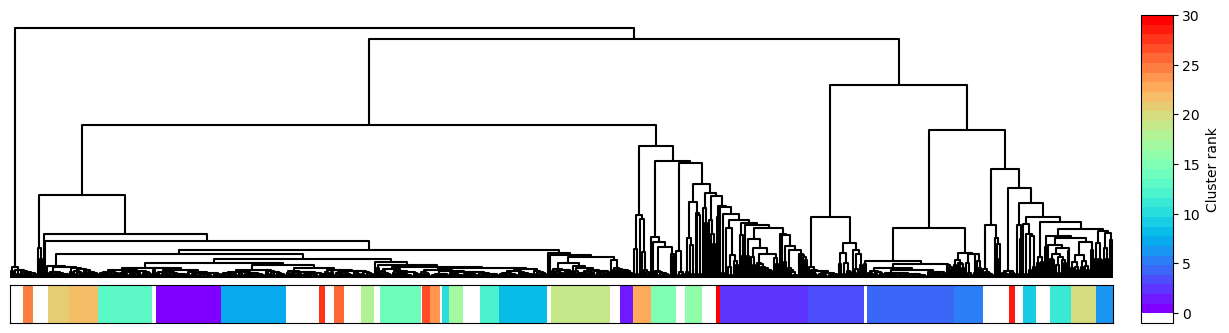

In [19]:
fig = plt.figure(figsize=(15, 4))
# fig.suptitle(f'{M} neighbours', fontsize=16)

gs0 = GridSpec(1,2, figure=fig,width_ratios=[35,1], wspace=0.05)
gs1 = GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0],
                                                  height_ratios=[7,1],
                                                  hspace=0.05)
legend_ax = fig.add_subplot(gs0[1])


ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = sp.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0, above_threshold_color='black')
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()


ax = fig.add_subplot(gs1[1], sharex=ax_col_dendrogram)
colrow = ax.imshow(node_to_clusterid_arr[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cluster_cmap, interpolation='nearest')
ax.set_yticks([])
# ax.set_ylabel('cluster id', rotation=0, ha='right', va='center')
ax.set_xticks([])
plt.setp(ax.get_xticklabels(), visible=False)
fig.colorbar(colrow, cax=legend_ax, label='Cluster rank')
if save_things:
    plt.savefig(grn_fig_dir / 'f4a_dendrogram.pdf', dpi=300, transparent=True)
plt.show()

In [20]:
label_dict=tf_family_dict
go_meta_dict = go_meta_df.set_index('GO_term')['GO_meta'].to_dict()

In [21]:
# prepare the enriched cluster dataframe to save
to_save = cluster_df[cluster_df['e_num']>0].reset_index(drop=True)
to_save['GO_terms'] = to_save.GO_terms.apply(lambda x: [(str(i), go_meta_dict.get(i, '')) for i in x])
if save_things:
    to_save.to_csv(grn_processed_dir / 'grn_GO_enrichment.csv')
    to_save.to_csv(cwd.parent / 'grn_GO_enrichment.csv')

In [22]:
maxenriched_cluster = list(enriched_clusters[0])
Z_maxenriched = linkage(ud_vect_df.fillna(0.).loc[maxenriched_cluster], metric=metric, method=method) ####### linkage
# maxenriched_labels = [i + " : " + str(label_dict.get(i)) for i in maxenriched_cluster]
maxenriched_labels = [i + " (" + str(label_dict.get(i)) + ")" for i in maxenriched_cluster]


maxsized_cluster = list(sorted_enriched_clusters[0])
Z_maxsized = linkage(ud_vect_df.fillna(0.).loc[maxsized_cluster], metric=metric, method=method) ####### linkage
# maxsized_labels = [i + " : " + str(label_dict.get(i)) for i in maxsized_cluster]
maxsized_labels = [i + " (" +str(label_dict.get(i)) + ")"  for i in maxsized_cluster]



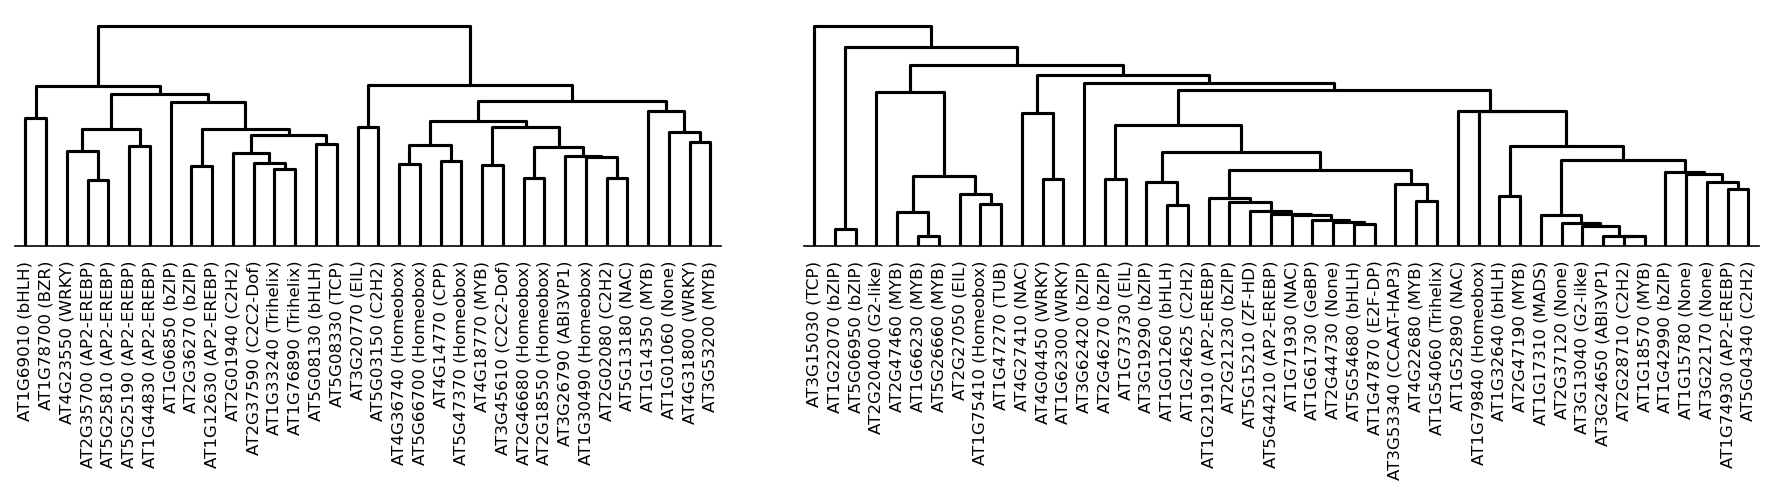

In [23]:
fig = plt.figure(figsize=(15, 2), dpi=150)

gs0 = GridSpec(1,2, figure=fig, wspace=0.1, width_ratios=[len(enriched_clusters[0]), len(sorted_enriched_clusters[0])])


dax_1= fig.add_subplot(gs0[1])
dax_2= fig.add_subplot(gs0[0])

Z_maxenriched_dendrogram = sp.cluster.hierarchy.dendrogram(Z_maxenriched,labels=maxenriched_labels, ax=dax_2, color_threshold=0, above_threshold_color='black',leaf_font_size=8)
Z_maxsized_dendrogram = sp.cluster.hierarchy.dendrogram(Z_maxsized,labels=maxsized_labels, ax=dax_1, color_threshold=0, above_threshold_color='black',leaf_font_size=8)

dax_1.set_xticks(dax_1.get_xticks(), dax_1.get_xticklabels(), rotation=90, va='center', ha='right', rotation_mode='anchor')# dax_1.set_axis_off()
dax_2.set_xticks(dax_2.get_xticks(), dax_2.get_xticklabels(), rotation=90, ha='right', va='center', rotation_mode='anchor')# dax_1.set_axis_off()
dax_1.set_yticks([])
dax_2.set_yticks([])

# dax_2.set_axis_off()
dax_1.spines[['right', 'top', 'left']].set_visible(False)
dax_2.spines[['right', 'top', 'left']].set_visible(False)
if save_things:
    plt.savefig(grn_fig_dir / 'f4bc_dendrogram.pdf', dpi=300, transparent=True)

plt.show()

In [24]:
largest_cluster_data = [(i, insert_line_break(go_meta_dict.get(i))) for i in cluster_df.sort_values('n', ascending=False).GO_terms.iloc[0]]

In [25]:
most_enriched_cluster_data = [(i, insert_line_break(go_meta_dict.get(i))) for i in cluster_df.sort_values('e_num', ascending=False).GO_terms.iloc[0]]

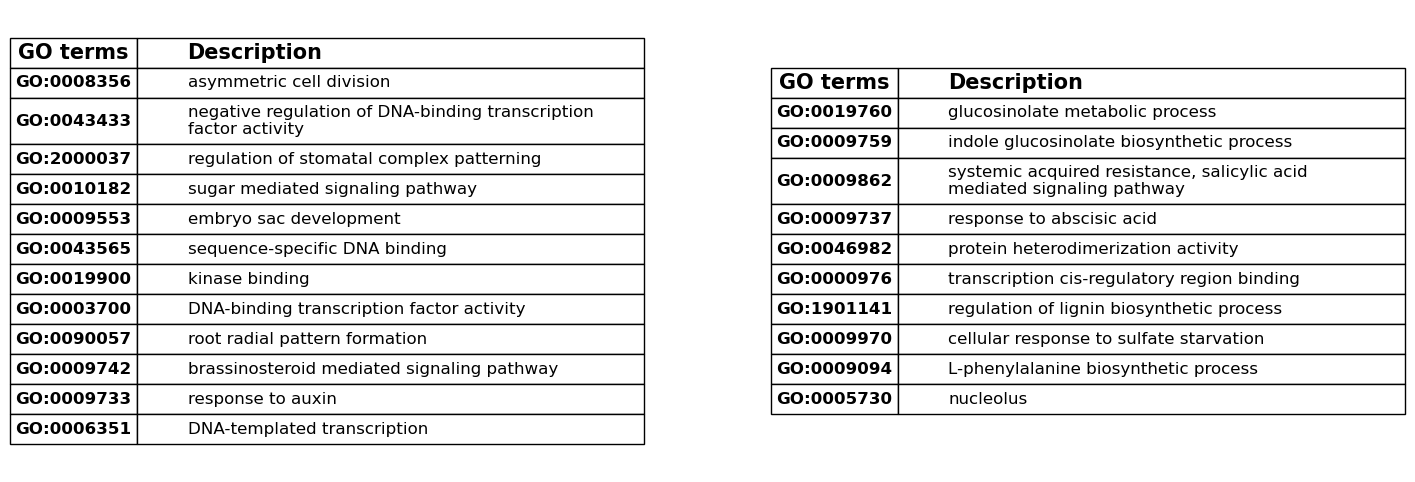

In [26]:
fig = plt.figure(figsize=(18, 6))
gs = GridSpec(1, 2, width_ratios=[1, 1], wspace=0.2)  # Equal space
# First table in top cell
ax1 = fig.add_subplot(gs[0])
ax1.axis('off')
make_GO_table(data=most_enriched_cluster_data, ax=ax1)

# Second table in bottom cell
ax2 = fig.add_subplot(gs[1])
ax2.axis('off')
make_GO_table(data=largest_cluster_data, ax=ax2)
if save_things:
    plt.savefig(grn_fig_dir / 'f4bc_table.png', dpi=300, transparent=True)
    plt.savefig(grn_fig_dir / 'f4bc_table.pdf', dpi=300, transparent=True)
plt.show()


In [27]:


# fig = plt.figure(figsize=(4, 10))

# gs0 = GridSpec(2,1, figure=fig,height_ratios=[35,1], wspace=0.05, hspace=0.1)
# gs1 = GridSpecFromSubplotSpec(1,2, subplot_spec=gs0[0],
#                                                   width_ratios=[7,1],
#                                                   wspace=0.05)
# legend_ax = fig.add_subplot(gs0[1])

# ax_col_dendrogram = fig.add_subplot(gs1[0])
# col_dendrogram = sp.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram,orientation='left', color_threshold=0, above_threshold_color='black', no_labels=True)


# xind = col_dendrogram['leaves']
# xmin,xmax = ax_col_dendrogram.get_xlim()


# ax = fig.add_subplot(gs1[1], ) # sharex=ax_col_dendrogram
# colrow = ax.imshow(node_to_clusterid_arr[xind][::-1].reshape((1,-1)).T, aspect='auto', extent=[xmin,xmax,0,1], cmap=cluster_cmap, interpolation='nearest')
# ax.set_yticks([])
# # ax.set_xlabel('Cluster rank', rotation=0, ha='center', va='top')
# ax.set_xticks([])
# plt.setp(ax.get_xticklabels(), visible=False)
# fig.colorbar(colrow, cax=legend_ax, label='Cluster rank', orientation='horizontal')
# if save_things:
#     plt.savefig(grn_fig_dir / 's1_smalldendrogram.png', dpi=300)
# # plt.tight_layout()
# plt.show()


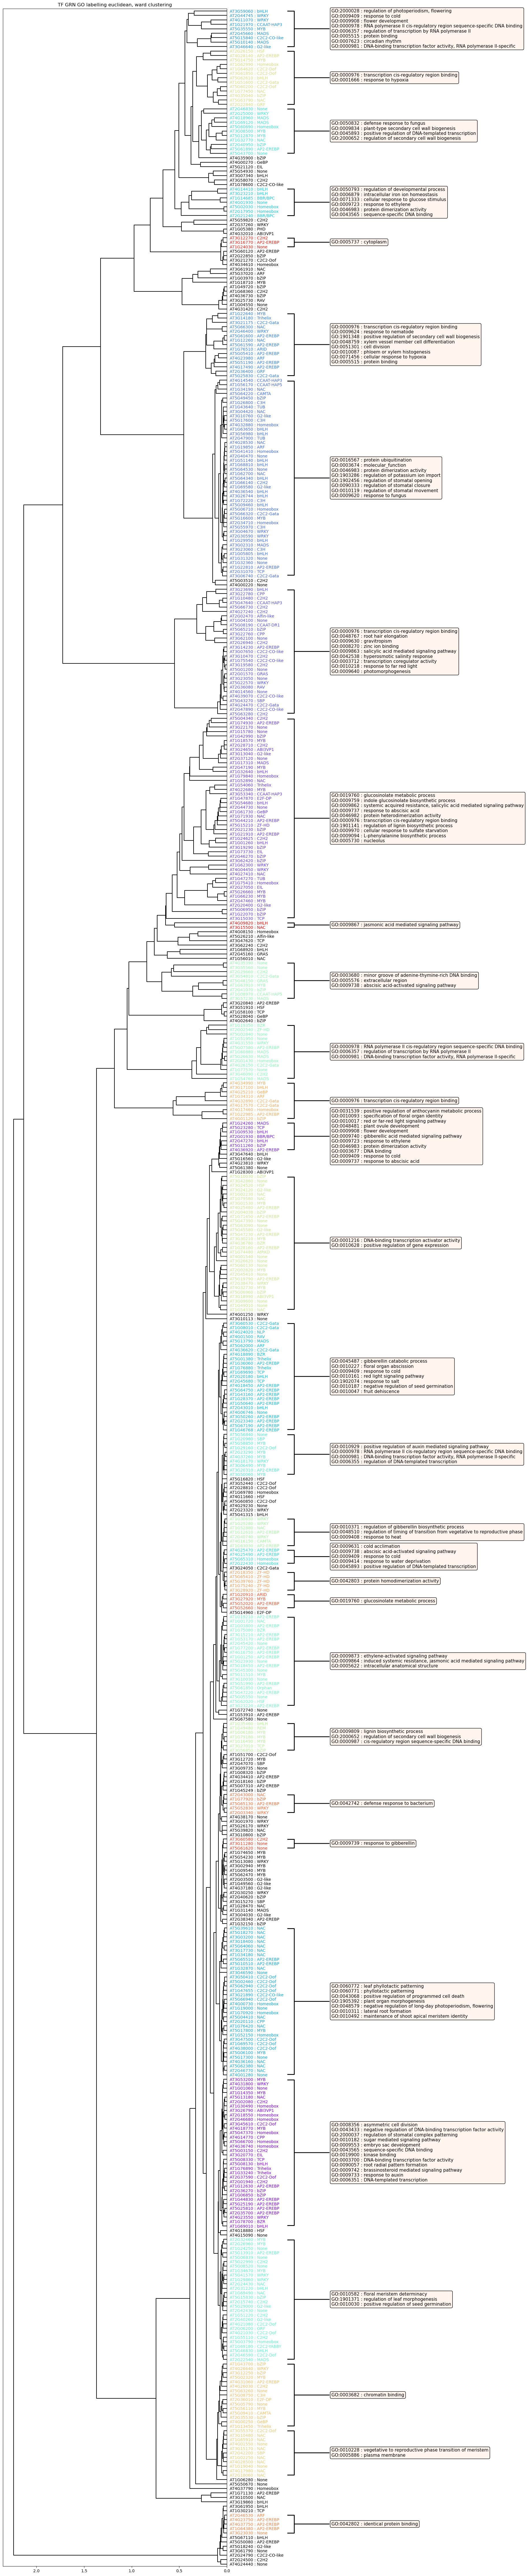

In [28]:
metric='euclidean'
method='ward'

ind_to_id = ud_vect_df.index.values

Z = linkage(ud_vect_df.fillna(0.), metric=metric, method=method) ####### linkage
label_dict=tf_family_dict
t=0
title_str=f'TF GRN GO labelling {metric}, {method} clustering'
labels=ind_to_id
clusters=enriched_clusters
size = len(labels)*80/400 
plt.figure(figsize=(10,size))
only_clusters = set(np.hstack(clusters))
if label_dict:
    clstr_labels = [i + " : " + str(label_dict.get(i)) for i in labels]

else:
    clstr_labels=labels
dendrograms = dendrogram(Z, labels=clstr_labels, get_leaves=True, orientation='left', above_threshold_color='black', color_threshold=t);


colors = cm.rainbow(np.linspace(0,1,len(clusters)))
ax = plt.gca()
bbox_args = dict(boxstyle="round", fc="#FFF5EE")

arrow_args = dict(arrowstyle="->")
ylbls = ax.get_ymajorticklabels()
for i in range(len(colors)):
    clstr = clusters[i]
    # print(clstr)
    for lbl in ylbls:
        label_colors = {'True' : colors[i], 'False' : 'black'}
        id_name = lbl.get_text().split(" : ")[0]
        is_clstr = id_name in clstr
        if is_clstr:
            lbl.set_color(label_colors[str(is_clstr)])

for key, value in cluster_df_todict.items():
    ith_cluster = value['cluster']
    e_num = value['e_num']
    n = value['n']
    go_terms = value['GO_terms']
    
    ith_indices = []
    for leaf_label in ylbls:
        node = leaf_label.get_text().split(" : ")[0]
        if node in ith_cluster:
            ith_indices.append(leaf_label.get_position()[1]) # get y position

    mn_pos, mx_pos = ith_indices[0], ith_indices[-1]

    pos_mid = (mn_pos+mx_pos)/2

    pos_range = mx_pos-mn_pos
    go_desc = [i+ ' : ' + go_meta_dict[i] for i in go_terms]
    text = '\n'.join(go_desc)
    # print(go_terms[0])
    # if len(go_desc) > 5:
    #     text = '\n'.join(go_desc[:5]) + f'\n{e_num} total' 
    ax.annotate(''.join(text),
                xy=(-0.7,pos_mid), xycoords="data",
                xytext=(-1.1,pos_mid),
                #  textcoords=OffsetFrom(ax.bbox, (0, 0), "points"),
                ha="left", va="center",
                bbox=bbox_args,fontsize=11,
                arrowprops=dict(arrowstyle=f'-[, widthB={pos_range/20}, lengthB=1.5', lw=2.0, color='k'), annotation_clip=False)


plt.yticks(fontsize=10)
plt.title(title_str)
if save_things:
    plt.savefig(grn_fig_dir / 's1_TF_GRN_GO_clustering_BH_all_GO_annotated.pdf', bbox_inches='tight')
plt.show()

# Food web:

In [29]:
# cwd = Path.cwd()
fw_processed_dir = cwd.parent / 'data' / 'foodweb' / 'processed'
fw_fig_dir = cwd.parent / 'figures' / 'foodweb'

if save_things:
    fw_fig_dir.mkdir(parents=True, exist_ok=True)

In [30]:
fw_df, meta_df_filtered, meta_fine_df_filtered, meta_fine_df_2_filtered = prep_foodweb_data()

In [31]:
fw_data = {'fw': fw_df, 'meta_f': meta_df_filtered, 'meta_ff': meta_fine_df_filtered, 'meta_fff': meta_fine_df_2_filtered}

vectors = {}
for key in ['f', 'ff', 'fff']: # coarseness of food web animal labelling: more 'f's the finer...
    v = pd.read_parquet( fw_processed_dir / f'{key}_vectors.parquet')
    vectors[f'{key}_vectors'] = v

In [32]:
mode = 'fff' # which level of coarseness in the food web animal labelling to use
fw_meta = fw_data[f'meta_{mode}']
fw_vectors = vectors[f'{mode}_vectors']

unique_types = fw_meta['type'].unique()
in_cols = [i + '_in' for i in unique_types]
out_cols = [i + '_out' for i in unique_types]

In [33]:
fw_label_meta = fw_data[f'meta_f'] # use the coarsest labelling for visualisation


In [34]:
metric = 'euclidean'
method = 'ward'

ind_to_id = fw_vectors.index.values
Z = linkage(fw_vectors.fillna(0).iloc[:, :-2], metric=metric, method=method) 

In [35]:
meta_dict = fw_label_meta.set_index('node').type.to_dict()
types_unique = fw_label_meta.type.unique()
ind_to_meta = [meta_dict.get(i) for i in ind_to_id]

types_to_numeric =dict(zip(types_unique, [0,0,0,0,0,1,1,1,2,2,2,2,2,3,4,5,5,5,5])) # reassign the types to a numeric value
types_unique = set(types_to_numeric.values())

ind_to_numeric_meta = [types_to_numeric.get(meta) for meta in ind_to_meta]

numeric_to_types = {}
for t, numeric in types_to_numeric.items():
    l = numeric_to_types.get(numeric, list())
    l.append(t)
    numeric_to_types[numeric] = l

numeric_to_typestr = []
for numeric, tlist in numeric_to_types.items():
    numeric_to_typestr.append(', '.join(numeric_to_types[numeric]))

numeric_meta_dict = dict(zip(fw_label_meta.node, fw_label_meta.type.apply(types_to_numeric.get)))


In [36]:
# Generate a colormap for unique types
colormap = plt.colormaps['viridis']
norm = plt.Normalize(vmin=0, vmax=len(types_unique) - 1)
colors = [colormap(norm(i)) for i in range(len(types_unique))]
type_cmap = plt.matplotlib.colors.ListedColormap(colors)


In [37]:
cutoff = 0.2
t = cutoff*max(Z[:,2])

exact_clustering_from_cols = dict()
small_clstr = set()
assigned=set()

# rawcolours = np.array(dendrograms['leaves_color_list'])
rawcolours = fcluster(Z=Z, t=t, criterion='distance') 


for i in list(set(rawcolours)): # remove the "other" unlcustered nodes
    if i != 'C000000':
        col_cl = set(np.array(ind_to_id)[np.where(rawcolours==i)])
        if len(col_cl) > 1: # don't take clusters of size 1
            exact_clustering_from_cols[i] = col_cl
            assigned |= col_cl
        else:
            small_clstr |= col_cl
exact_clustering_from_cols = {rank+1: v for rank, (_, v) in enumerate(sorted(exact_clustering_from_cols.items(), key=lambda item: len(item[1]), reverse=True))}
cluster_labels = list(exact_clustering_from_cols.keys())
cluster_lens = [len(exact_clustering_from_cols.get(i)) for i in cluster_labels]

cluster_lens_tuple = sorted(list(zip(cluster_labels, cluster_lens)), key=lambda x: -x[1])

plot_n = None

clusters_to_plot = [exact_clustering_from_cols.get(i[0]) for i in cluster_lens_tuple[:plot_n]]
cluster_labels_to_plot = [i[0] for i in cluster_lens_tuple[:plot_n]]
palette = cm.rainbow(np.linspace(0,1,len(cluster_labels_to_plot))) # sns.color_palette('husl', n_colors=plot_n).as_hex()
palette_dict = dict(zip(cluster_labels_to_plot, [to_hex(i) for i in palette]))

leaf_clabel_dict = {}
for key, val in exact_clustering_from_cols.items():
    for i in val:
        leaf_clabel_dict[i] = key


# animals_of_interest = np.hstack([list(i) for i in clusters_to_plot])

leaf_palette = {}
dflt_col = "black"   # Unclustered black

for i in ind_to_id:
    leaf_palette[i] = palette_dict.get(leaf_clabel_dict.get(i), dflt_col)

# Sorted cluster labels and their colors
cluster_labels = sorted(palette_dict.keys())
cluster_colors = [palette_dict[k] for k in cluster_labels]

# Create colormap and norm
cmap = mcolors.ListedColormap(cluster_colors)
bounds = np.array(cluster_labels + [max(cluster_labels) + 1]) - 0.5  # to center color ticks
norm = mcolors.BoundaryNorm(bounds, cmap.N)

link_cols = {}
for i, i12 in enumerate(Z[:,:2].astype(int)):
  c1, c2 = (link_cols[x] if x > len(Z) else leaf_palette[ind_to_id[x]]
    for x in i12)
  link_cols[i+1+len(Z)] = c1 if c1 == c2 else dflt_col


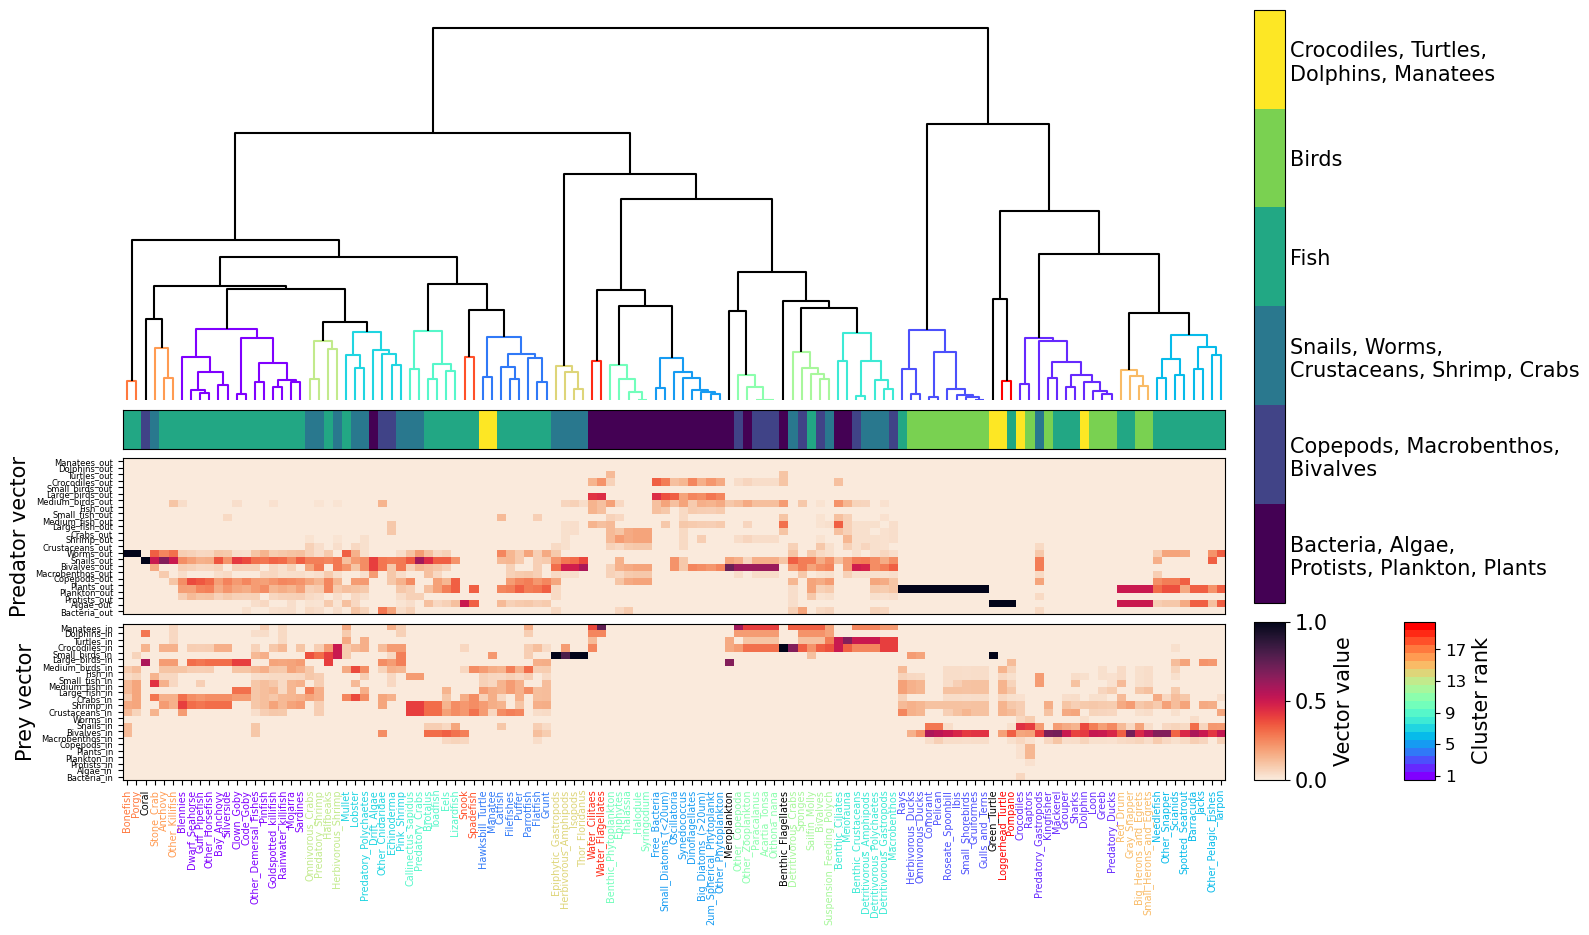

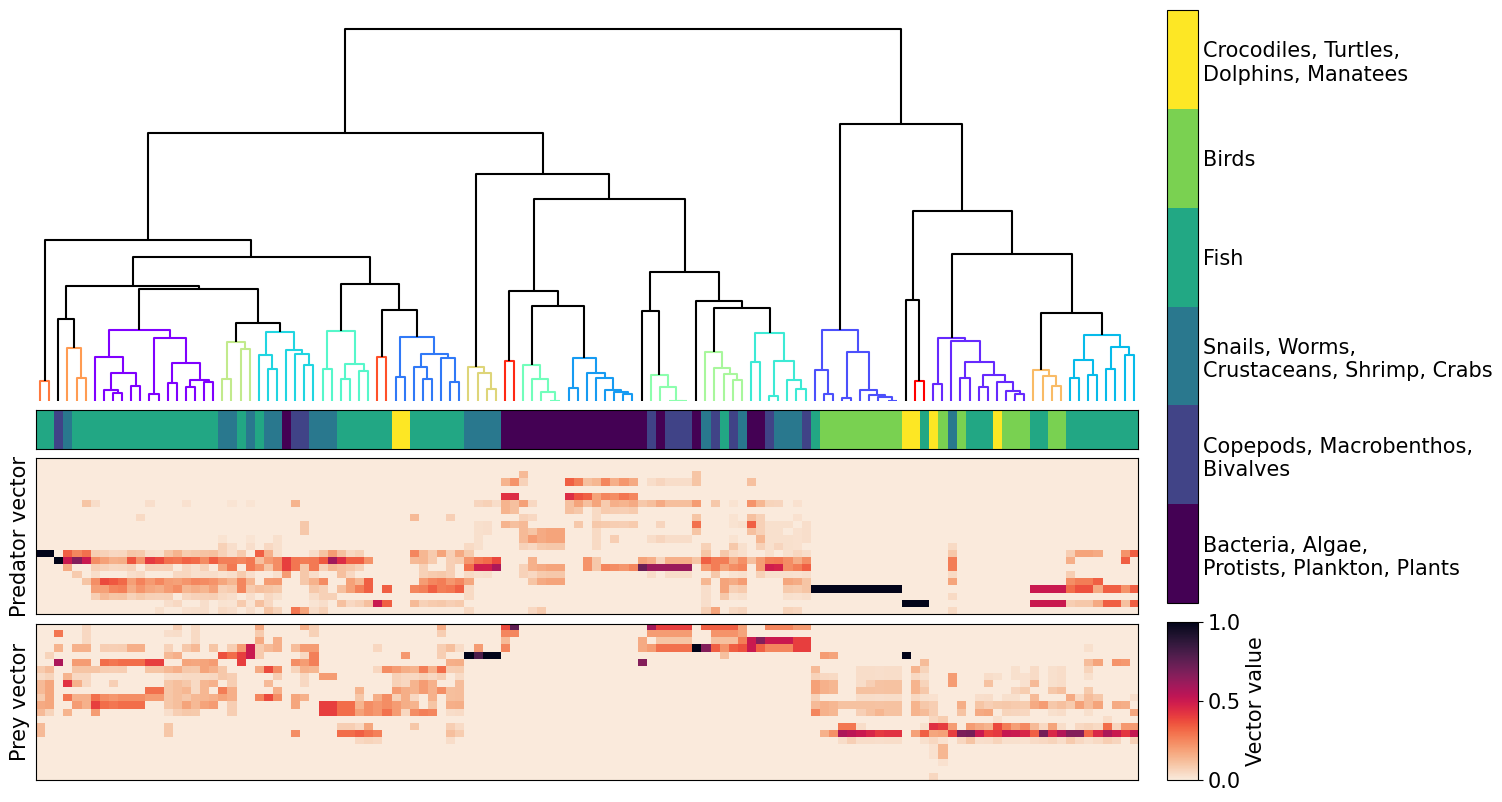

In [38]:

for full in [True, False]:
    fig = plt.figure(figsize=(15, 10))

    # Define gridspecs for layout
    gs0 = GridSpec(1, 2, figure=fig, width_ratios=[35, 1], wspace=0.05)
    gs1 = GridSpecFromSubplotSpec(4, 1, subplot_spec=gs0[0], height_ratios=[10, 1, 4, 4], hspace=0.05)
    gs2 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1], height_ratios=[15, 4], hspace=0.05)

    # Add subplots
    legend_ax = fig.add_subplot(gs2[0])
    ax_col_dendrogram = fig.add_subplot(gs1[0])


    sec_legend_ax = fig.add_subplot(gs2[1])


    # Plot dendrogram
    col_dendrogram = dendrogram(
        Z, ax=ax_col_dendrogram, color_threshold=0, above_threshold_color='black',
        link_color_func=lambda x: link_cols[x]
    )
    ax_col_dendrogram.set_axis_off()

    # Get x-axis indices and limits
    xind = col_dendrogram['leaves']
    xmin, xmax = ax_col_dendrogram.get_xlim()

    # Plot metadata heatmap
    arr = np.array([numeric_meta_dict.get(animal) for animal in ind_to_id])
    ax_meta = fig.add_subplot(gs1[1], sharex=ax_col_dendrogram)
    colrow = ax_meta.imshow(
        arr[xind].reshape((1, -1)), aspect='auto', extent=[xmin, xmax, 0, 1],
        cmap=type_cmap, interpolation='nearest'
    )
    ax_meta.set_yticks([])
    ax_meta.set_xticks([])

    # Add colorbar for metadata
    fig.colorbar(colrow, cax=legend_ax, label='')
    yticks = np.linspace(*legend_ax.get_ylim(), len(types_unique) + 1)[:-1] + (legend_ax.get_ylim()[1] / len(types_unique) / 2)
    legend_ax.set_yticks(ticks=yticks)
    newstrings = []
    for i in numeric_to_typestr:
        splitstring = i.split(' ')
        if len(splitstring)>2:
            splitstring = splitstring[:1] + [splitstring[1] + '\n' + splitstring[2]] + splitstring[3:]
            # splitstring[2] += '\n'
        splitstring = ' '.join(splitstring)

        newstrings.append(splitstring)

    legend_ax.set_yticklabels(newstrings, size=15)
    legend_ax.tick_params(length=0)

    # Plot predator and prey vectors
    predator_vec_ax = fig.add_subplot(gs1[2])
    prey_vec_ax = fig.add_subplot(gs1[3])

    pv_img = predator_vec_ax.imshow(
        fw_vectors.loc[:, out_cols].iloc[xind, :-2].fillna(0).T, cmap='rocket_r',
        aspect='auto', extent=[0, 1, 0, 1], interpolation='nearest'
    )
    prey_vec_ax.imshow(
        fw_vectors.loc[:, in_cols].iloc[xind, :-2].fillna(0).T, cmap='rocket_r',
        aspect='auto', extent=[0, 1, 0, 1], interpolation='nearest'
    )

    # Style predator and prey vector axes
    for ax, label in zip([predator_vec_ax, prey_vec_ax], ['Predator vector', 'Prey vector']):
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_ylabel(label, rotation=90, size=15)

    # Add colorbar for predator vector
    vcbar = plt.colorbar(pv_img, cax=sec_legend_ax)
    vcbar.set_label('Vector value', size=15)  # Set label text and size
    sec_legend_ax.set_yticks([0, 0.5, 1])
    sec_legend_ax.tick_params(axis='y', labelsize=15)
    suffix= ''
    if full:
        for ax, label, col_label in zip([predator_vec_ax, prey_vec_ax], ['Predator vector', 'Prey vector'], [out_cols, in_cols]):
            ax.set_yticks(np.linspace(0, 1, len(col_label)+1)[:-1] + 1/(2*(len(col_label)+1)))
            ax.set_yticklabels(col_label, ha='right', size=6)

        prey_vec_ax.set_xticks(np.linspace(0, 1, len(ind_to_id[xind])+1)[:-1] + 1/(2*(len(ind_to_id[xind])+1)))
        prey_vec_ax.set_xticklabels(ind_to_id[xind], rotation=90, ha='center', size=7)
        suffix = '_full'
        xlbls = ax.get_xmajorticklabels()
        for lbl in xlbls:
            animal_label = lbl.get_text()
            colour = leaf_palette.get(animal_label, False)
            if colour:
                lbl.set_color(colour)
        cbar_ax = fig.add_subplot(gs2[1])

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax)
        cbar.set_label('Cluster rank', size=15)
        cbar_ax.set_yticks(cluster_labels[::4])
        # cbar.ax.set_yticklabels([str(i) for i in cluster_labels])  # or custom labels
        cbar.ax.tick_params(labelsize=12)
        cbar_ax.tick_params(which='minor', bottom=False, top=False, left=False, right=False)

        pos = cbar_ax.get_position()

        # Adjust values: (x0, y0, width, height)
        new_pos = [pos.x0 + 0.1, pos.y0, pos.width, pos.height]
        cbar_ax.set_position(new_pos)

    if save_things:
        plt.savefig(fw_fig_dir / f'f1a_dendrogram{suffix}.pdf', dpi=300, bbox_inches='tight', transparent=True)
        plt.savefig(fw_fig_dir / f'f1a_dendrogram{suffix}.png', dpi=300, bbox_inches='tight', transparent=True)

    plt.show()


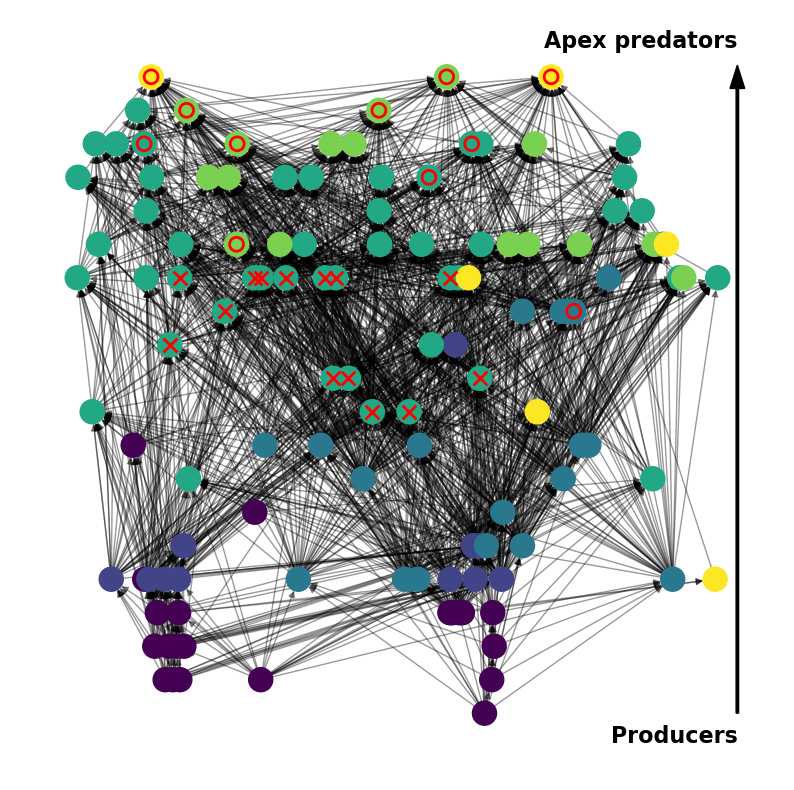

In [39]:

# Create a colormap for clusters
clustercmap = {val: type_cmap(ind) for ind, val in enumerate(list(types_unique))}
assignment = dict(zip(ind_to_id, arr))
partition = [[node for node, val in assignment.items() if val == cl] for cl in list(types_unique)]

# Create a directed graph and add edges
fw_g = nx.DiGraph()
fw_g.add_edges_from(fw_df[['prey', 'predator']].to_numpy(), alpha=0.4)
plt.figure(figsize=(10, 10))

# Generate positions for nodes
try:
    pos = nx.nx_agraph.graphviz_layout(fw_g, prog='dot')  # Requires Graphviz

except:
    pos = nx.spring_layout(fw_g, seed=0)
    print('Graphviz layout failed, using spring layout instead.')

pos = {key: (val[0], -val[1]) for key, val in pos.items()}

# Plot the graph
for ind, nodelist in enumerate(partition):
    nx.draw_networkx_nodes(fw_g, nodelist=nodelist, node_color=[clustercmap.get(ind) for _ in nodelist], pos=pos)

# Add labels or markers for clusters of interest
shapes = ['x', 'o']  # Define marker shapes
for cluster, label in zip(clusters_to_plot, shapes):
    fc = 'none' if label == 'o' else 'red'
    for node in cluster:
        x, y = pos[node]
        plt.scatter(x, y, marker=label, color='red', s=100, zorder=5, facecolor=fc, linewidths=2)

# Draw edges
nx.draw_networkx_edges(fw_g, pos=pos, alpha=0.4)

# Add an arrow to indicate hierarchy
max_x = max(x for x, y in pos.values())
max_y = max(y for x, y in pos.values())
min_y = min(y for x, y in pos.values())
arrow_x = max_x + 800
arrow_length = max_y - min_y + 25

plt.arrow(
    x=arrow_x, y=min_y, dx=0, dy=arrow_length,
    head_width=600, head_length=50, fc='black', ec='black',
    length_includes_head=True, width=100
)

# Add text labels for hierarchy
plt.text(arrow_x, min_y + arrow_length + 50, 'Apex predators', va='center', ha='right', fontsize=16, weight='bold')
plt.text(arrow_x, min_y - 50, 'Producers', va='center', ha='right', fontsize=16, weight='bold')

# Finalize plot
plt.axis('off')

# Save the plot if required
if save_things:
    plt.savefig(fw_fig_dir / 'f1b_foodweb_graph.png', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig(fw_fig_dir / 'f1b_foodweb_graph.pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()


# Recipe network:

In [40]:
# cwd = Path.cwd()
rn_processed_dir = cwd.parent / 'data' / 'recipe' / 'processed'
rn_fig_dir = cwd.parent / 'figures' / 'recipe'

if save_things:
    rn_fig_dir.mkdir(parents=True, exist_ok=True)

In [41]:
rn_df, meta_df = prep_recipe_data()
cuisine_list = meta_df.cuisine.dropna().unique()
recipe_list = rn_df.r_id.dropna().unique()

ingredient_list = list(set(rn_df.ingredient.dropna().unique()) - {''})
rn_df = rn_df[rn_df['ingredient'].isin(ingredient_list)].reset_index(drop=True)

In [42]:
cs_i_vectors = pd.read_parquet(rn_processed_dir / 'cs_i_vectors.parquet')

is_c_vectors = pd.read_parquet(rn_processed_dir / 'is_c_vectors.parquet')

In [43]:
metric = 'euclidean'
method = 'ward'
ind_to_id = np.array(ingredient_list)

Z = linkage(cs_i_vectors.loc[ingredient_list, cuisine_list], metric=metric, method=method) ####### linkage


In [44]:
cutoff = 0.3
t = cutoff*max(Z[:,2])

exact_clustering_from_cols = dict()
small_clstr = set()
assigned=set()

rawcolours = fcluster(Z=Z, t=t, criterion='distance') 


for i in list(set(rawcolours)): # remove the "other" unlcustered nodes
    if i != 'C0':
        col_cl = np.array(ind_to_id)[np.where(rawcolours==i)]
        if len(col_cl) > 1: # don't take clusters of size 1
            exact_clustering_from_cols[i] = col_cl
            assigned |= set(col_cl)
        else:
            small_clstr |= set(col_cl)
exact_clustering_from_cols = {rank+1: v for rank, (_, v) in enumerate(sorted(exact_clustering_from_cols.items(), key=lambda item: len(item[1]), reverse=True))}
cluster_labels = list(exact_clustering_from_cols.keys())
cluster_lens = [len(exact_clustering_from_cols.get(i)) for i in cluster_labels]

cluster_lens_tuple = sorted(list(zip(cluster_labels, cluster_lens)), key=lambda x: -x[1])


plot_n = None

clusters_to_plot = [exact_clustering_from_cols.get(i[0]) for i in cluster_lens_tuple[:plot_n]]
cluster_labels_to_plot = [i[0] for i in cluster_lens_tuple[:plot_n]]
palette = cm.rainbow(np.linspace(0,1,len(cluster_labels_to_plot))) # sns.color_palette('husl', n_colors=plot_n).as_hex()
palette_dict = dict(zip(cluster_labels_to_plot, [to_hex(i) for i in palette]))

leaf_clabel_dict = {}
for key, val in exact_clustering_from_cols.items():
    for i in val:
        leaf_clabel_dict[i] = key


# animals_of_interest = np.hstack([list(i) for i in clusters_to_plot])

leaf_palette = {}
dflt_col = "black"   # Unclustered black

for i in ind_to_id:
    leaf_palette[i] = palette_dict.get(leaf_clabel_dict.get(i), dflt_col)


# Sorted cluster labels and their colors
cluster_labels = sorted(palette_dict.keys())
cluster_colors = [palette_dict[k] for k in cluster_labels]

# Create colormap and norm
cmap = mcolors.ListedColormap(cluster_colors)
bounds = np.array(cluster_labels + [max(cluster_labels) + 1]) - 0.5  # to center color ticks
norm = mcolors.BoundaryNorm(bounds, cmap.N)

link_cols = {}
for i, i12 in enumerate(Z[:,:2].astype(int)):
  c1, c2 = (link_cols[x] if x > len(Z) else leaf_palette[ind_to_id[x]]
    for x in i12)
  link_cols[i+1+len(Z)] = c1 if c1 == c2 else dflt_col


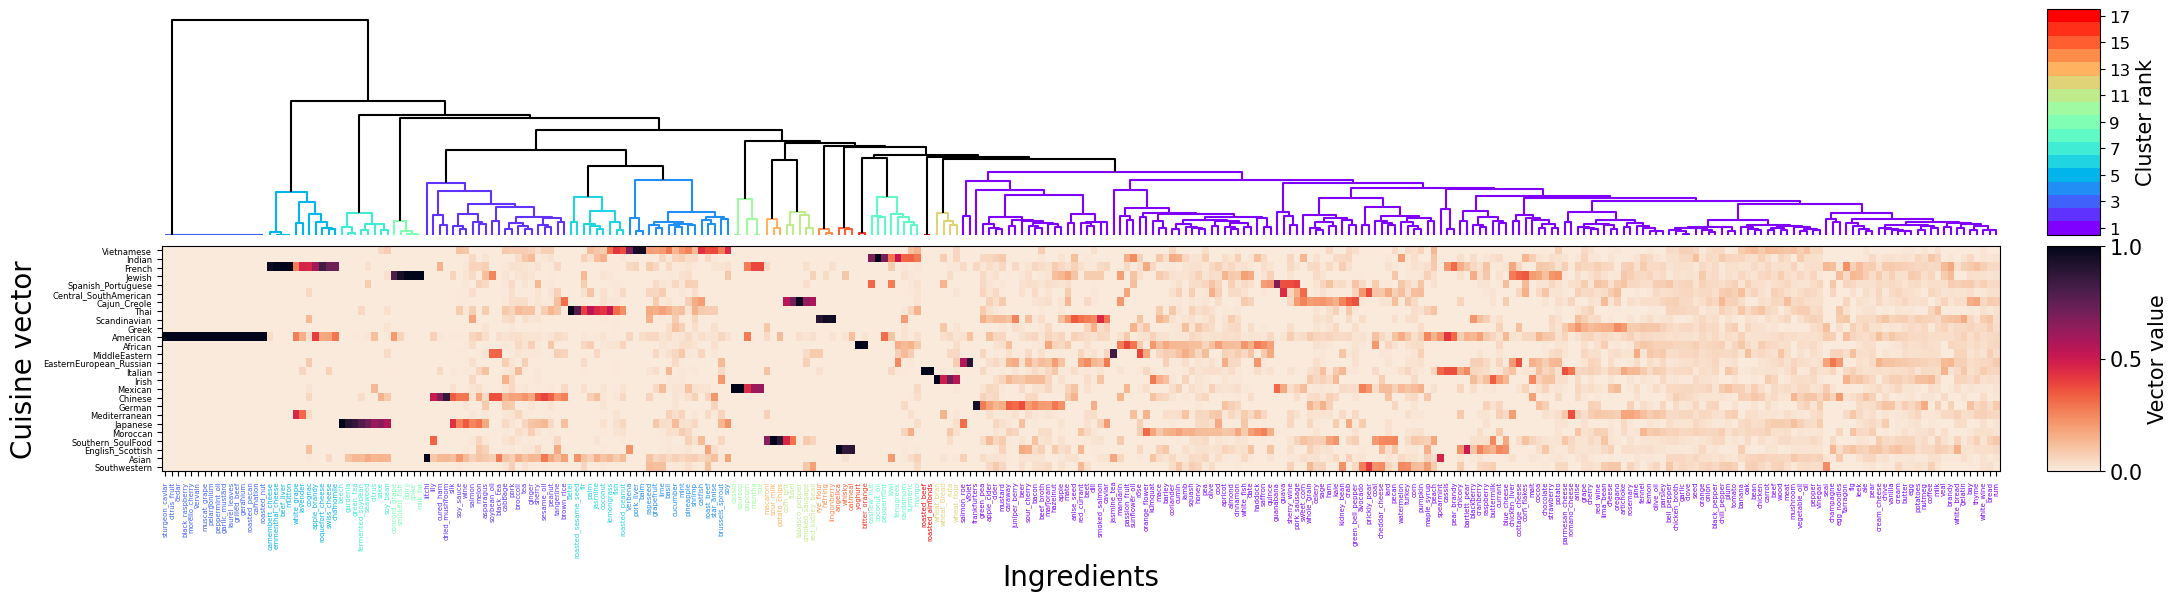

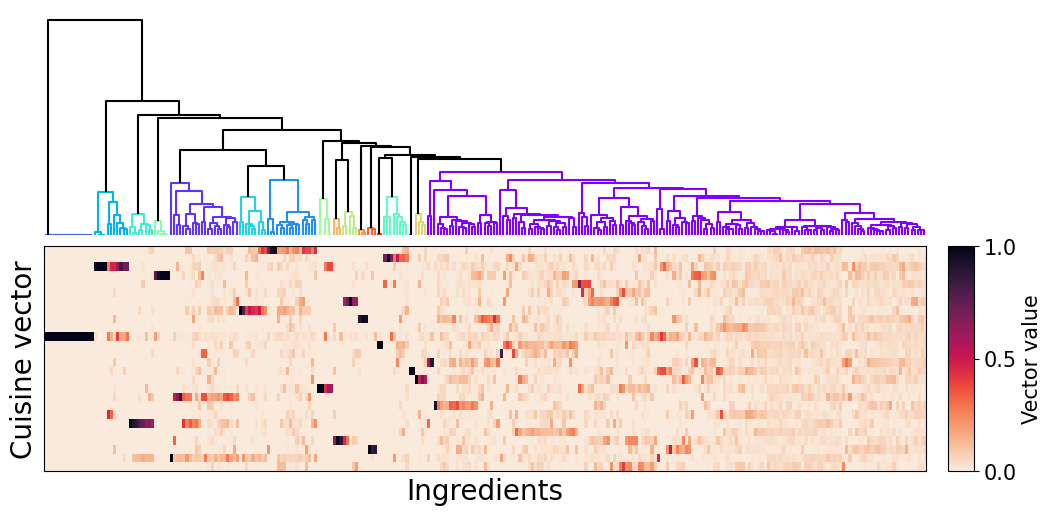

In [45]:

for full in [True, False]:
    figsize = (25, 6) if full else (12, 6)
    fig = plt.figure(figsize=figsize)

    # Define gridspecs for layout
    gs0 = GridSpec(1, 2, figure=fig, width_ratios=[35, 1], wspace=0.05)
    gs1 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0], height_ratios=[1, 1], hspace=0.05)
    gs2 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1], height_ratios=[1, 1], hspace=0.05)

    # Add subplots
    legend_ax = fig.add_subplot(gs2[1])
    ax_col_dendrogram = fig.add_subplot(gs1[0])

    col_dendrogram = dendrogram(
        Z, ax=ax_col_dendrogram, color_threshold=0, above_threshold_color='black',link_color_func=lambda x: link_cols[x] )

    ax_col_dendrogram.set_axis_off()

    # Get x-axis indices and limits
    xind = col_dendrogram['leaves']
    xmin, xmax = ax_col_dendrogram.get_xlim()

    # Plot heatmap
    ax = fig.add_subplot(gs1[1], sharex=ax_col_dendrogram)
    colrow = ax.imshow(
        cs_i_vectors.loc[ingredient_list, cuisine_list].iloc[xind].to_numpy().T,
        cmap='rocket_r', aspect='auto', extent=[xmin, xmax, 0, 1], interpolation='nearest'
    )
    ax.set_yticks([])
    ax.set_ylabel('Cuisine vector', rotation=90, size=20)
    ax.set_xlabel('Ingredients', size=20)
    ax.set_xticks([])

    # Add colorbar
    vcbar = fig.colorbar(colrow, cax=legend_ax, orientation='vertical')
    legend_ax.set_yticks([0, 0.5, 1])
    legend_ax.tick_params(axis='y', labelsize=15)
    vcbar.set_label('Vector value', size=15)  # Set label text and size

    # Add detailed labels if `full`
    if full:
        ax.set_yticks(np.linspace(0, 1, len(cuisine_list) + 1)[:-1] + 1 / (2 * (len(cuisine_list) + 1)))
        ax.set_yticklabels(cuisine_list[::-1], ha='right', size=6)

        ax.set_xticks(np.linspace(xmin, xmax, len(ind_to_id[xind]) + 1)[:-1] + (xmax - xmin) / (2 * (len(ind_to_id[xind]) + 1)))
        ax.set_xticklabels(ind_to_id[xind], rotation=90, ha='center', size=5)
        xlbls = ax.get_xmajorticklabels()
        for lbl in xlbls:
            label = lbl.get_text()
            colour = leaf_palette.get(label, False)
            if colour:
                lbl.set_color(colour)
        cbar_ax = fig.add_subplot(gs2[0])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax, ticks=cluster_labels[::2])
        # cbar = fig.colorbar(sm, cax=cbar_ax, label='Cluster rank', ticks=cluster_labels)
        cbar.set_label('Cluster rank', size=15)
        cbar.ax.tick_params(labelsize=12)
        cbar_ax.tick_params(which='minor', bottom=False, top=False, left=False, right=False)


    # Save the figure if required
    if save_things:
        suffix = '_full' if full else ''
        plt.savefig(rn_fig_dir / f'f2a_dendrogram{suffix}.pdf', dpi=300, bbox_inches='tight', transparent=True)
        plt.savefig(rn_fig_dir / f'f2a_dendrogram{suffix}.png', dpi=300, bbox_inches='tight', transparent=True)

    plt.show()


In [46]:
metric = 'euclidean'
method = 'ward'
ind_to_id = np.array(ingredient_list)
# ind_to_id = cs_i_vectors.columns.values



In [47]:
show_clusters = [clusters_to_plot[i] for i in [6, 5]]

zs = []
lens = []

for cluster in show_clusters:
    Z = linkage(cs_i_vectors.loc[list(cluster), cuisine_list], metric=metric, method=method) ####### linkage
    zs.append(Z)
    lens.append(len(cluster))



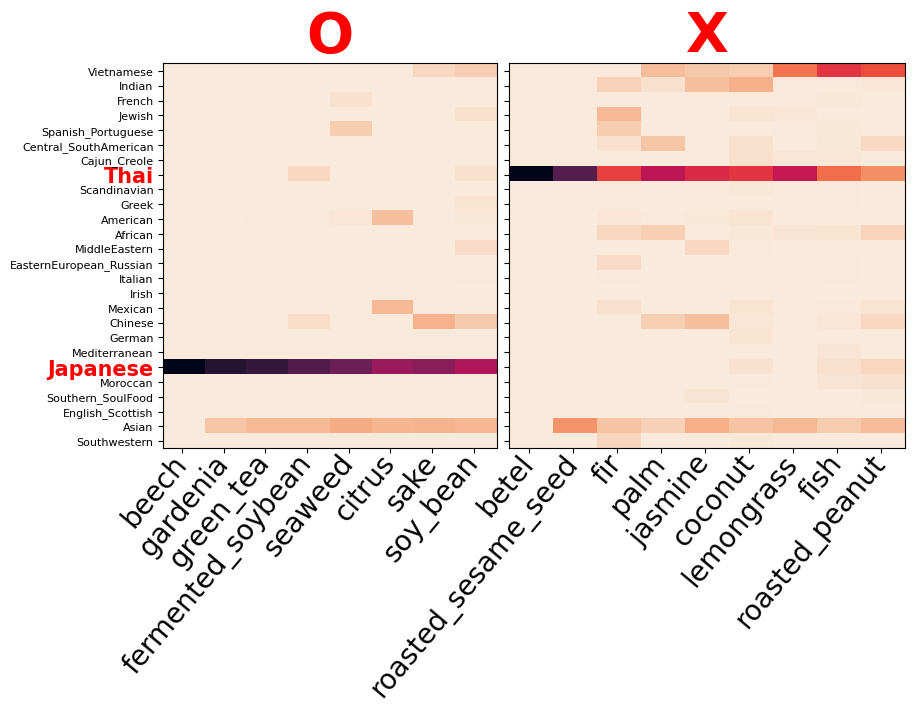

In [48]:
full = False
save_things = False

figsize = (10, 5)
fig = plt.figure(figsize=figsize)

# Define gridspecs for layout
len_ratio = [int(np.round(i/sum(lens) * 35)) for i in lens]
gs0 = GridSpec(1, len(lens) + 1, figure=fig, width_ratios=len_ratio + [1], wspace=0.05)

# gs1 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0], height_ratios=[1, 1], hspace=0.05)

# gs2 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1], height_ratios=[1, 1], hspace=0.05)
gs_last = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[-1], height_ratios=[1, 3], hspace=0.05)

# Add subplots
# legend_ax = fig.add_subplot(gs_last[1])

# Plot dendrogram
# col_dendrogram = dendrogram(
#     Z, ax=ax_col_dendrogram, color_threshold=0, above_threshold_color='black',
#     link_color_func=lambda x: link_cols[x]
# )

titles = ['O', 'X']
# Plot heatmap
for ind, cluster_Z in enumerate(zs):

    # gs_pannel = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[ind], height_ratios=[1, 3], hspace=0.05)

    # ax_col_dendrogram = fig.add_subplot(gs_pannel[0])

    col_dendrogram = dendrogram(
        cluster_Z, color_threshold=0, above_threshold_color='black', no_plot=True)

    # ax_col_dendrogram.set_axis_off()

    # Get x-axis indices and limits
    xind = col_dendrogram['leaves']
    xmin, xmax = 0, 1 #ax_col_dendrogram.get_xlim()

    ax = fig.add_subplot(gs0[ind])
    colrow = ax.imshow(
        cs_i_vectors.loc[show_clusters[ind], cuisine_list].iloc[xind].to_numpy().T,
        cmap='rocket_r', aspect='auto', extent=[xmin, xmax, 0, 1], interpolation='nearest'
    )
    # ax.set_xlabel('Ingredients', size=20)
    ax.set_xticks(np.linspace(xmin, xmax, len(show_clusters[ind][xind]) + 1)[:-1] + (xmax - xmin) / (2 * (len(show_clusters[ind]) + 1)))
    ax.set_xticklabels(show_clusters[ind][xind], rotation=50, ha='right', size=20, va='center', rotation_mode="anchor")
    ax.set_yticks(np.linspace(0, 1, len(cuisine_list) + 1)[:-1] + 1 / (2 * (len(cuisine_list) + 1)))
    ax.set_yticklabels([])
    if ind ==0:
        ax.set_yticks(np.linspace(0, 1, len(cuisine_list) + 1)[:-1] + 1 / (2 * (len(cuisine_list) + 1)))
        ax.set_yticklabels(cuisine_list[::-1], ha='right', size=8)
        for label in ax.get_yticklabels():
            if label.get_text() in ['Japanese', 'Thai']:  # Set desired tick values to red
                label.set_color('red')
                label.set_fontsize(15)
                label.set_fontweight('bold')

        # ax.set_ylabel('Cuisine vector', rotation=90, size=20)
    ax.set_title(titles[ind], color='red', size=40, fontweight='bold')


# Save the figure if required
if save_things:
    suffix = '_full' if full else ''
    plt.savefig(rn_fig_dir / f'f2b_dendrogram{suffix}.pdf', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig(rn_fig_dir / f'f2b_dendrogram{suffix}.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()


In [49]:
metric = 'euclidean'
method = 'ward'
ind_to_id = np.array(cuisine_list)
Z = linkage(is_c_vectors.loc[ind_to_id, ingredient_list], metric=metric, method=method) ####### linkage


In [50]:

# def find_branch_point(Z, leaf_indices):
#     n = Z.shape[0] + 1  # number of original observations

#     # Each cluster is a set of leaf indices it contains
#     clusters = {i: {i} for i in range(n)}

#     for i, (c1, c2, dist, _) in enumerate(Z):
#         new_cluster = clusters[int(c1)] | clusters[int(c2)]
#         clusters[n + i] = new_cluster

#         if set(leaf_indices).issubset(new_cluster):
#             return n + i, dist  # Return cluster ID and its height (y-coordinate)

#     return None, None

# cluster_id, height = find_branch_point(Z, leaf_labels)

In [51]:
cutoff = 0.4
t = cutoff*max(Z[:,2])

exact_clustering_from_cols = dict()
small_clstr = set()
assigned=set()

# rawcolours = np.array(dendrograms['leaves_color_list'])
rawcolours = fcluster(Z=Z, t=t, criterion='distance') 


for i in list(set(rawcolours)): # remove the "other" unlcustered nodes
    if i != 'C0':
        col_cl = set(np.array(ind_to_id)[np.where(rawcolours==i)])
        if len(col_cl) > 1: # don't take clusters of size 1
            exact_clustering_from_cols[i] = col_cl
            assigned |= col_cl
        else:
            small_clstr |= col_cl
exact_clustering_from_cols = {rank+1: v for rank, (_, v) in enumerate(sorted(exact_clustering_from_cols.items(), key=lambda item: len(item[1]), reverse=True))}
cluster_labels = list(exact_clustering_from_cols.keys())
cluster_lens = [len(exact_clustering_from_cols.get(i)) for i in cluster_labels]

cluster_lens_tuple = sorted(list(zip(cluster_labels, cluster_lens)), key=lambda x: -x[1])

plot_n = None

clusters_to_plot = [exact_clustering_from_cols.get(i[0]) for i in cluster_lens_tuple[:plot_n]]
cluster_labels_to_plot = [i[0] for i in cluster_lens_tuple[:plot_n]]
palette = cm.rainbow(np.linspace(0,1,len(cluster_labels_to_plot))) # sns.color_palette('husl', n_colors=plot_n).as_hex()
palette_dict = dict(zip(cluster_labels_to_plot, [to_hex(i) for i in palette]))

leaf_clabel_dict = {}
for key, val in exact_clustering_from_cols.items():
    for i in val:
        leaf_clabel_dict[i] = key


# animals_of_interest = np.hstack([list(i) for i in clusters_to_plot])

leaf_palette = {}
dflt_col = "black"   # Unclustered black

for i in ind_to_id:
    leaf_palette[i] = palette_dict.get(leaf_clabel_dict.get(i), dflt_col)

# Sorted cluster labels and their colors
cluster_labels = sorted(palette_dict.keys())
cluster_colors = [palette_dict[k] for k in cluster_labels]

# Create colormap and norm
cmap = mcolors.ListedColormap(cluster_colors)
bounds = np.array(cluster_labels + [max(cluster_labels) + 1]) - 0.5  # to center color ticks
norm = mcolors.BoundaryNorm(bounds, cmap.N)

link_cols = {}
for i, i12 in enumerate(Z[:,:2].astype(int)):
  c1, c2 = (link_cols[x] if x > len(Z) else leaf_palette[ind_to_id[x]]
    for x in i12)
  link_cols[i+1+len(Z)] = c1 if c1 == c2 else dflt_col


In [52]:

# Dendrogram data
ddata = dendrogram(Z, no_plot=True)
# leaf_coords = dict(zip(ddata['ivl'], ddata['leaves']))
leaf_coords = dict(zip(ddata['leaves'], ddata['ivl']))
col_cl = np.where(rawcolours == 2)[0]

# Get leaf indices
leaf_labels = col_cl
# Get their indices
leaf_indices = [leaf_coords[label] for label in leaf_labels]
reversed_link_cols = {}
for ind, val in enumerate(link_cols.items()):
    key, color = val
    # print(ind)
    # print(key)
    if color not in reversed_link_cols:
        reversed_link_cols[color] = []
    reversed_link_cols[color].append(ind)


In [53]:

# icoord and dcoord are the x and y values of the dendrogram linkages.
# Z encodes the order in which the clusters are formed, i.e. sorted by y values

# But the order in which icoord and dcoord are stored in the plotting is by 
# the order in which they are drawn, i.e. the x values. We must correct this to correspond.  

icdc = np.hstack([ddata['icoord'], ddata['dcoord']])
sorted_icdc = np.vstack(sorted(icdc, key=lambda x: x[5]))


In [54]:

link_coords = []
for key, val in reversed_link_cols.items():
    if key != 'black':
        cluster_icdc = sorted_icdc[val]
        argy = np.argmax(cluster_icdc[:,5])
        y = cluster_icdc[:,5][argy]
        # x = ((cluster_icdc[argy][3]) + (cluster_icdc[argy][0]))/2
        x =  (cluster_icdc[argy][0])

        link_coords.append([x, y, key])

link_coords = sorted(link_coords, key=lambda x:x[0]) # sort back to plotting sequence

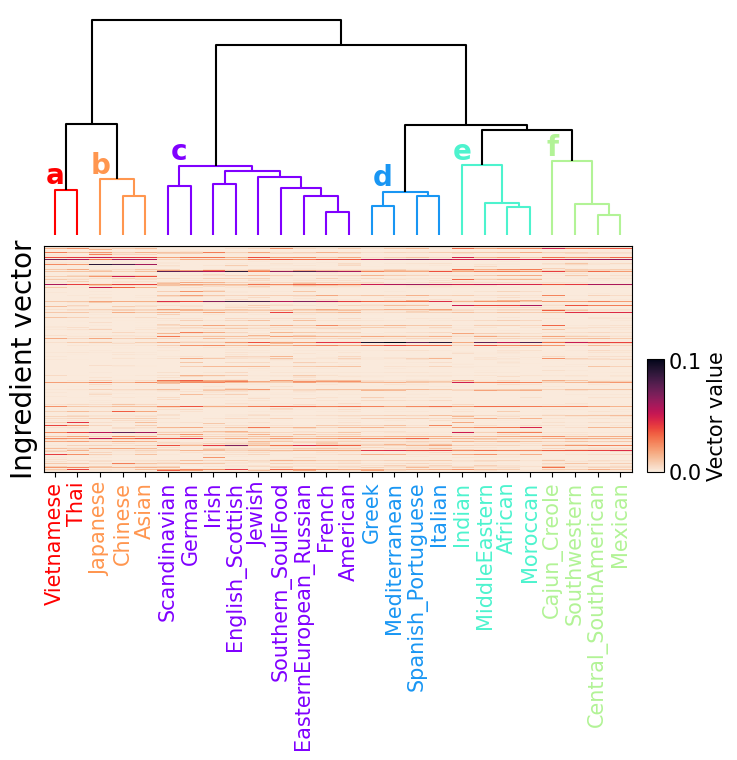

In [ ]:
# save_things = False
fig = plt.figure(figsize=(8, 6))

gs0 = GridSpec(1,2, figure=fig,width_ratios=[35,1], wspace=0.05)
gs1 = GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0],
                                                  height_ratios=[1,1],
                                                  hspace=0.05)

gs2 = GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[1],
                                                  height_ratios=[3,1],
                                                  hspace=0.05)
# cbar_ax = fig.add_subplot(gs2[0])

legend_ax = fig.add_subplot(gs2[1])


ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0 , above_threshold_color='black', link_color_func=lambda x: link_cols[x])
ax_col_dendrogram.set_axis_off()


labels = 'abcdef'

for plotitems, l in zip(link_coords, labels):
    x, y, c = plotitems
    ax_col_dendrogram.text(x, y, l, color=c, ha='center', va='bottom', size=20, bbox=dict(pad=2, fc='none', ec='None'), weight='bold')


xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

# arr = np.array([numeric_meta_dict.get(animal) for animal in ind_to_id])

# heatmap ax:
ax = fig.add_subplot(gs1[1], sharex=ax_col_dendrogram)
# colrow = ax.imshow(arr[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cmap, interpolation='nearest')

colrow = ax.imshow(is_c_vectors.loc[ind_to_id, ingredient_list].iloc[xind].to_numpy().T, cmap='rocket_r', aspect='auto', extent=[xmin,xmax,0,1], interpolation='nearest')

ax.set_yticks([])
ax.set_ylabel('Ingredient vector', rotation=90, size=20)
# ax.set_xlabel('Cuisines', rotation=0, size=20)


ax.set_xticklabels(ind_to_id[xind], fontsize=15)
# ax.xaxis.set_tick_params(rotation=30, labelsize=10, ha='right', va='center')
# plt.setp(ax.get_xticklabels(), visible=False)

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right', verticalalignment='center', rotation_mode='anchor')
legend_ax.tick_params(length=0)        
# fig.colorbar(colrow, cax=legend_ax, orientation='vertical')

vcbar = fig.colorbar(colrow, cax=legend_ax, orientation='vertical')
vcbar.set_label(label='Vector value', fontsize=15)

legend_ax.tick_params(axis='y', labelsize=15)

# # rank colourbar:
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = fig.colorbar(sm, cax=cbar_ax, label='Cluster size rank', ticks=cluster_labels)
# cbar_ax.set_yticks(cluster_labels)
# # cbar.ax.set_yticklabels([str(i) for i in cluster_labels])  # or custom labels
# cbar.ax.tick_params(labelsize=12)
# cbar_ax.tick_params(which='minor', bottom=False, top=False, left=False, right=False)
# ax.axis("off")

# colour the leaves:
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    label = lbl.get_text()
    colour = leaf_palette.get(label, False)
    if colour:
        lbl.set_color(colour)
if save_things:
    plt.savefig(rn_fig_dir / 'f3a_dendrogram.pdf', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig(rn_fig_dir / f'f3a_dendrogram.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()